## Klasifikasi penyakit diabetes

# Anggota Kelompok

# 1. Fransisko Andrade Laiskodat (22.11.4665) IF03

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, mean
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# Inisialisasi SparkSession
spark = SparkSession.builder.appName("DiabetesClassification").getOrCreate()

# Load data
file_path = "/content/diabetes.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Tampilkan 5 baris pertama
data.show(5)

# Tipe data tiap kolom
data.printSchema()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nul

In [ ]:
# Summary statistik data
data.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

## pre-processing DataSet

In [ ]:
# Cek missing values
missing_values = data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns])
missing_values.show()

+---------------+-------+--------------+--------------+-------+---+------------------------+---+-------+
|Num_Pregnancies|Glucose|Blood_Pressure|Skin_Thickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+---------------+-------+--------------+--------------+-------+---+------------------------+---+-------+
|              0|      0|             0|             0|      0|  0|                       0|  0|      0|
+---------------+-------+--------------+--------------+-------+---+------------------------+---+-------+



In [ ]:
from pyspark.sql.functions import when, col, sum

# Hitung jumlah angka nol di setiap kolom, kecuali kolom "Outcome"
zero_counts = data.select(
    *[(sum(when(col(c) == 0, 1).otherwise(0)).alias(c)) for c in data.columns if c != "Outcome"]
)

# Menampilkan hasil
zero_counts.show()


+---------------+-------+--------------+--------------+-------+---+------------------------+---+
|Num_Pregnancies|Glucose|Blood_Pressure|Skin_Thickness|Insulin|BMI|DiabetesPedigreeFunction|Age|
+---------------+-------+--------------+--------------+-------+---+------------------------+---+
|            111|      5|            35|           227|    374| 11|                       0|  0|
+---------------+-------+--------------+--------------+-------+---+------------------------+---+



In [ ]:
# Filter baris dengan angka nol di kolom Glucose, BloodPressure, dan BMI
filtered_data = data.filter(
    (col("Glucose") != 0) &
    (col("Blood_Pressure") != 0) &
    (col("BMI") != 0)
)

# Menampilkan DataFrame yang dihasilkan
filtered_data.show()

+---------------+-------+--------------+--------------+-------+----+------------------------+---+-------+
|Num_Pregnancies|Glucose|Blood_Pressure|Skin_Thickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+---------------+-------+--------------+--------------+-------+----+------------------------+---+-------+
|              6|    148|            72|            35|      0|33.6|                   0.627| 50|      1|
|              1|     85|            66|            29|      0|26.6|                   0.351| 31|      0|
|              8|    183|            64|             0|      0|23.3|                   0.672| 32|      1|
|              1|     89|            66|            23|     94|28.1|                   0.167| 21|      0|
|              0|    137|            40|            35|    168|43.1|                   2.288| 33|      1|
|              5|    116|            74|             0|      0|25.6|                   0.201| 30|      0|
|              3|     78|            50|      

In [ ]:
from pyspark.sql.functions import when, col, sum

# Hitung jumlah angka nol di setiap kolom
zero_counts = filtered_data.agg(
    *[(sum(when(col(c) == 0, 1).otherwise(0)).alias(c)) for c in filtered_data.columns]
)

# Menampilkan hasil jumlah nol per kolom
zero_counts.show()

# Hitung jumlah baris yang dihapus
initial_row_count = data.count()
filtered_row_count = filtered_data.count()
deleted_rows = initial_row_count - filtered_row_count

print("Deleted rows: ", deleted_rows)

+---------------+-------+--------------+--------------+-------+---+------------------------+---+-------+
|Num_Pregnancies|Glucose|Blood_Pressure|Skin_Thickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+---------------+-------+--------------+--------------+-------+---+------------------------+---+-------+
|             99|      0|             0|           192|    332|  0|                       0|  0|    475|
+---------------+-------+--------------+--------------+-------+---+------------------------+---+-------+

Deleted rows:  44


In [ ]:
from pyspark.sql.functions import mean, when, col

# Hitung nilai rata-rata dari kolom SkinThickness
avg_skin_thickness = data.agg(mean(col("Skin_Thickness"))).collect()[0][0]

# Ganti angka nol dengan nilai rata-rata kolom
data = data.withColumn(
    "Skin_Thickness",
    when(col("Skin_Thickness") == 0, avg_skin_thickness).otherwise(col("Skin_Thickness"))
)

# Tampilkan DataFrame yang dihasilkan
data.show()


+---------------+-------+--------------+------------------+-------+----+------------------------+---+-------+
|Num_Pregnancies|Glucose|Blood_Pressure|    Skin_Thickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+---------------+-------+--------------+------------------+-------+----+------------------------+---+-------+
|              6|    148|            72|              35.0|      0|33.6|                   0.627| 50|      1|
|              1|     85|            66|              29.0|      0|26.6|                   0.351| 31|      0|
|              8|    183|            64|20.536458333333332|      0|23.3|                   0.672| 32|      1|
|              1|     89|            66|              23.0|     94|28.1|                   0.167| 21|      0|
|              0|    137|            40|              35.0|    168|43.1|                   2.288| 33|      1|
|              5|    116|            74|20.536458333333332|      0|25.6|                   0.201| 30|      0|
|         

In [ ]:
# Hapus kolom Insulin dari dataset
data = data.drop("Insulin")

# Tampilkan DataFrame yang dihasilkan
data.show()

+---------------+-------+--------------+------------------+----+------------------------+---+-------+
|Num_Pregnancies|Glucose|Blood_Pressure|    Skin_Thickness| BMI|DiabetesPedigreeFunction|Age|Outcome|
+---------------+-------+--------------+------------------+----+------------------------+---+-------+
|              6|    148|            72|              35.0|33.6|                   0.627| 50|      1|
|              1|     85|            66|              29.0|26.6|                   0.351| 31|      0|
|              8|    183|            64|20.536458333333332|23.3|                   0.672| 32|      1|
|              1|     89|            66|              23.0|28.1|                   0.167| 21|      0|
|              0|    137|            40|              35.0|43.1|                   2.288| 33|      1|
|              5|    116|            74|20.536458333333332|25.6|                   0.201| 30|      0|
|              3|     78|            50|              32.0|31.0|                  

In [ ]:
# Rename kolom untuk kemudahan (opsional)
data = data.withColumnRenamed("Pregnancies", "Num_Pregnancies") \
           .withColumnRenamed("BloodPressure", "Blood_Pressure") \
           .withColumnRenamed("SkinThickness", "Skin_Thickness")


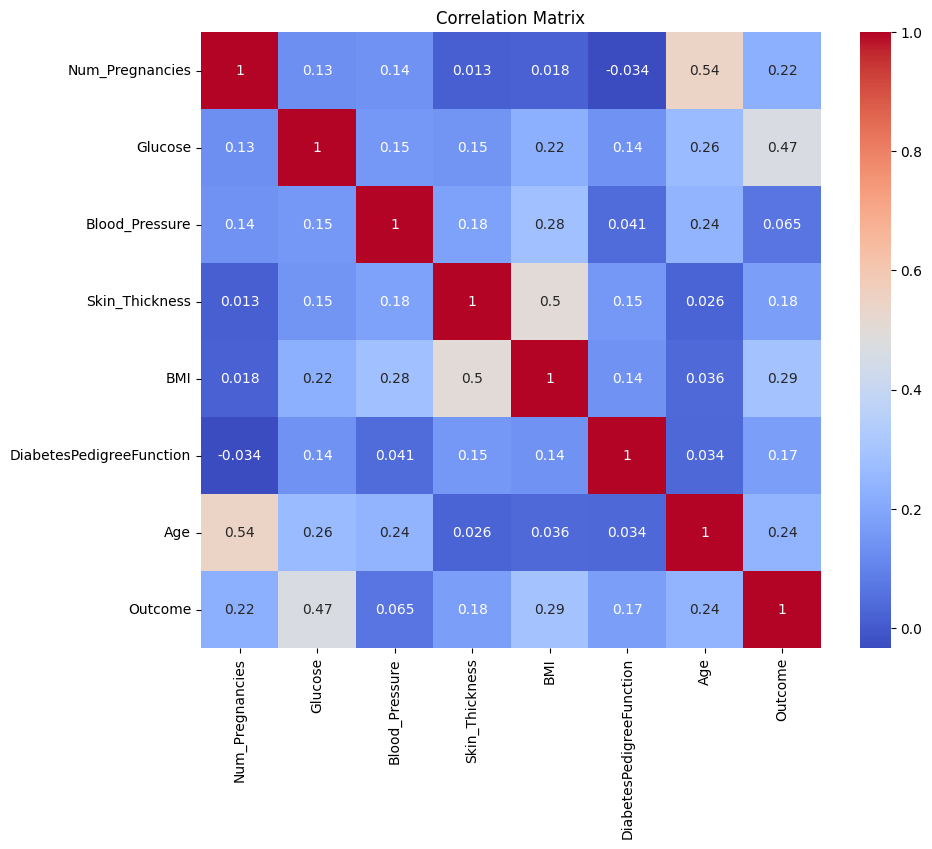

In [ ]:
# Korelasi antar fitur
numeric_data = data.toPandas()
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
from pyspark.sql.functions import mean

# Isi missing values (jika ada) dengan rata-rata kolom
for column in data.columns:
    if column != 'Outcome':  # Tidak mengubah kolom target
        mean_value = data.select(mean(col(column))).first()[0]
        data = data.fillna({column: mean_value})

# Konfirmasi tidak ada missing values
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

# Tampilkan ulang data yang telah diproses
data.show(5)

# Pembagian data: 80% untuk training, 20% untuk testing
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


+---------------+-------+--------------+--------------+---+------------------------+---+-------+
|Num_Pregnancies|Glucose|Blood_Pressure|Skin_Thickness|BMI|DiabetesPedigreeFunction|Age|Outcome|
+---------------+-------+--------------+--------------+---+------------------------+---+-------+
|              0|      0|             0|             0|  0|                       0|  0|      0|
+---------------+-------+--------------+--------------+---+------------------------+---+-------+

+---------------+-------+--------------+------------------+----+------------------------+---+-------+
|Num_Pregnancies|Glucose|Blood_Pressure|    Skin_Thickness| BMI|DiabetesPedigreeFunction|Age|Outcome|
+---------------+-------+--------------+------------------+----+------------------------+---+-------+
|              6|    148|            72|              35.0|33.6|                   0.627| 50|      1|
|              1|     85|            66|              29.0|26.6|                   0.351| 31|      0|
|   

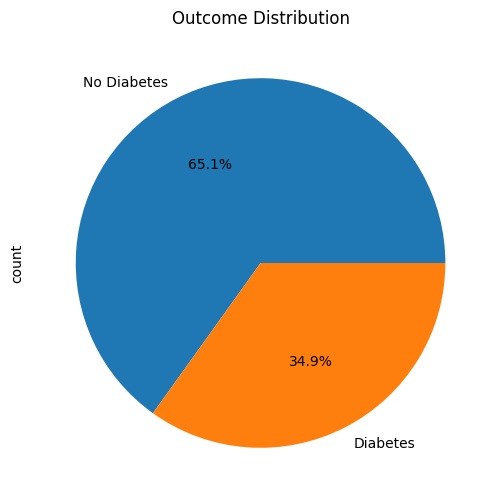

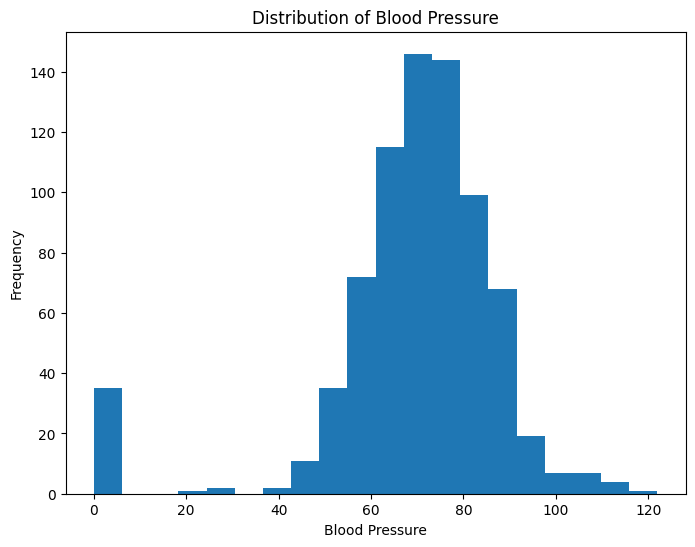

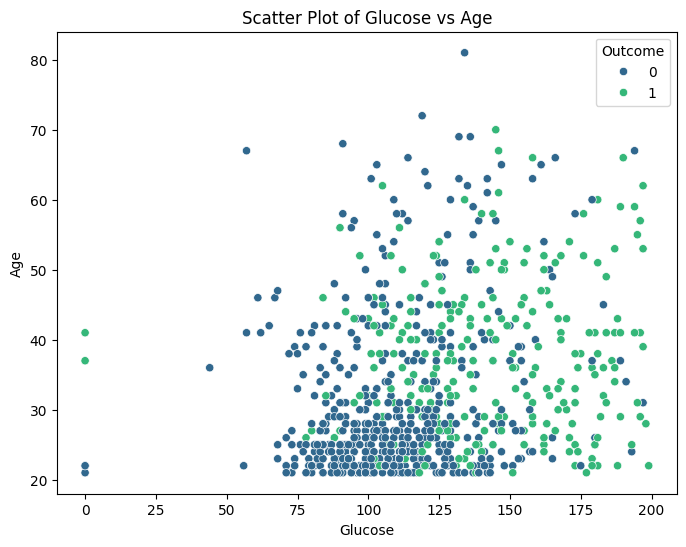

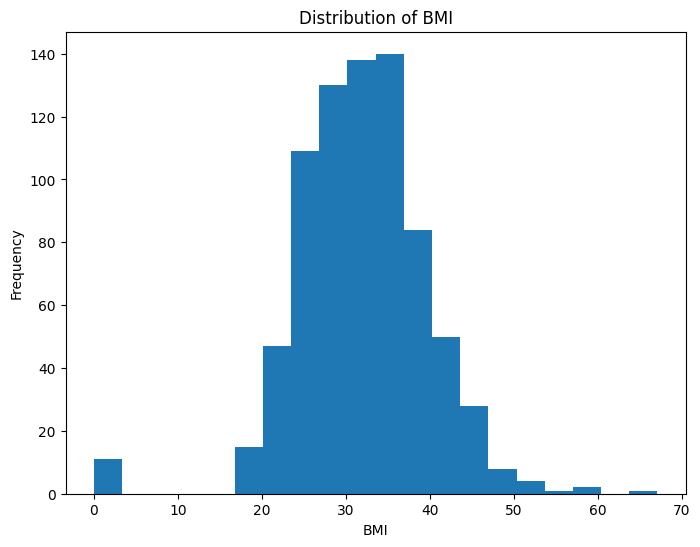

In [ ]:
# Konversi Spark DataFrame ke Pandas untuk visualisasi
pandas_data = data.toPandas()

# Pie chart untuk distribusi Outcome
outcome_counts = pandas_data['Outcome'].value_counts()
outcome_counts.plot.pie(autopct='%1.1f%%', figsize=(6, 6), labels=['No Diabetes', 'Diabetes'], title='Outcome Distribution')
plt.show()

# Bar chart untuk distribusi kolom Blood Pressure
pandas_data['Blood_Pressure'].plot(kind='hist', bins=20, title='Distribution of Blood Pressure', figsize=(8, 6))
plt.xlabel('Blood Pressure')
plt.show()

# Scatter plot antara Glucose dan Age
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pandas_data, x='Glucose', y='Age', hue='Outcome', palette='viridis')
plt.title('Scatter Plot of Glucose vs Age')
plt.show()

# Histogram untuk distribusi kolom BMI
pandas_data['BMI'].plot(kind='hist', bins=20, title='Distribution of BMI', figsize=(8, 6))
plt.xlabel('BMI')
plt.show()


In [ ]:
from pyspark.ml.feature import VectorAssembler

# Daftar fitur (tanpa kolom target)
feature_columns = ["Num_Pregnancies", "Glucose", "Blood_Pressure", "Skin_Thickness", "BMI", "DiabetesPedigreeFunction", "Age"]

# VectorAssembler untuk menggabungkan kolom fitur
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transformasikan data
data_assembled = assembler.transform(data)
data_assembled.show()


+---------------+-------+--------------+------------------+----+------------------------+---+-------+--------------------+
|Num_Pregnancies|Glucose|Blood_Pressure|    Skin_Thickness| BMI|DiabetesPedigreeFunction|Age|Outcome|            features|
+---------------+-------+--------------+------------------+----+------------------------+---+-------+--------------------+
|              6|    148|            72|              35.0|33.6|                   0.627| 50|      1|[6.0,148.0,72.0,3...|
|              1|     85|            66|              29.0|26.6|                   0.351| 31|      0|[1.0,85.0,66.0,29...|
|              8|    183|            64|20.536458333333332|23.3|                   0.672| 32|      1|[8.0,183.0,64.0,2...|
|              1|     89|            66|              23.0|28.1|                   0.167| 21|      0|[1.0,89.0,66.0,23...|
|              0|    137|            40|              35.0|43.1|                   2.288| 33|      1|[0.0,137.0,40.0,3...|
|              5

In [ ]:
from pyspark.ml.feature import StandardScaler

# StandardScaler untuk standarisasi fitur
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Fit dan transformasikan data
scaler_model = scaler.fit(data_assembled)
scaled_data = scaler_model.transform(data_assembled)
scaled_data.show()


+---------------+-------+--------------+------------------+----+------------------------+---+-------+--------------------+--------------------+
|Num_Pregnancies|Glucose|Blood_Pressure|    Skin_Thickness| BMI|DiabetesPedigreeFunction|Age|Outcome|            features|      scaledFeatures|
+---------------+-------+--------------+------------------+----+------------------------+---+-------+--------------------+--------------------+
|              6|    148|            72|              35.0|33.6|                   0.627| 50|      1|[6.0,148.0,72.0,3...|[1.78063837321943...|
|              1|     85|            66|              29.0|26.6|                   0.351| 31|      0|[1.0,85.0,66.0,29...|[0.29677306220323...|
|              8|    183|            64|20.536458333333332|23.3|                   0.672| 32|      1|[8.0,183.0,64.0,2...|[2.37418449762590...|
|              1|     89|            66|              23.0|28.1|                   0.167| 21|      0|[1.0,89.0,66.0,23...|[0.29677306220

In [ ]:
# Pisahkan dataset menjadi data latih dan uji
train_data, test_data = scaled_data.randomSplit([0.8, 0.2], seed=42)

## 4 model yang diginakan
# 1. Logistic Regression
# 2. Random Forest
# 4. Gradient-Boosted Tree
# 5. Decision Tree

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Logistic Regression
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='Outcome', maxIter=50)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Evaluasi AUC (ROC Curve)
auc_evaluator = BinaryClassificationEvaluator(labelCol="Outcome", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
lr_auc = auc_evaluator.evaluate(lr_predictions)

# Evaluasi Akurasi, F1 Score, Precision, Recall
metric_evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction")
lr_accuracy = metric_evaluator.setMetricName("accuracy").evaluate(lr_predictions)
lr_f1 = metric_evaluator.setMetricName("f1").evaluate(lr_predictions)
lr_precision = metric_evaluator.setMetricName("weightedPrecision").evaluate(lr_predictions)
lr_recall = metric_evaluator.setMetricName("weightedRecall").evaluate(lr_predictions)

# Cetak hasil evaluasi
print("Logistic Regression Evaluation Metrics:")
print(f"AUC (ROC Curve): {lr_auc:.3f}")
print(f"Accuracy: {lr_accuracy:.3f}")
print(f"F1 Score: {lr_f1:.3f}")
print(f"Precision: {lr_precision:.3f}")
print(f"Recall: {lr_recall:.3f}")


Logistic Regression Evaluation Metrics:
AUC (ROC Curve): 0.858
Accuracy: 0.797
F1 Score: 0.792
Precision: 0.793
Recall: 0.797


In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Random Forest Classifier
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='Outcome', numTrees=10)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Evaluasi AUC (ROC Curve)
rf_auc = auc_evaluator.evaluate(rf_predictions)

# Evaluasi Akurasi, F1 Score, Precision, Recall
rf_accuracy = metric_evaluator.setMetricName("accuracy").evaluate(rf_predictions)
rf_f1 = metric_evaluator.setMetricName("f1").evaluate(rf_predictions)
rf_precision = metric_evaluator.setMetricName("weightedPrecision").evaluate(rf_predictions)
rf_recall = metric_evaluator.setMetricName("weightedRecall").evaluate(rf_predictions)

# Cetak hasil evaluasi
print("\nRandom Forest Evaluation Metrics:")
print(f"AUC (ROC Curve): {rf_auc:.3f}")
print(f"Accuracy: {rf_accuracy:.3f}")
print(f"F1 Score: {rf_f1:.3f}")
print(f"Precision: {rf_precision:.3f}")
print(f"Recall: {rf_recall:.3f}")



Random Forest Evaluation Metrics:
AUC (ROC Curve): 0.824
Accuracy: 0.797
F1 Score: 0.792
Precision: 0.793
Recall: 0.797


In [ ]:
from pyspark.ml.classification import GBTClassifier

# Gradient-Boosted Tree Classifier
gbt = GBTClassifier(featuresCol='scaledFeatures', labelCol='Outcome', maxIter=10)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

# Evaluasi AUC (ROC Curve)
gbt_auc = auc_evaluator.evaluate(gbt_predictions)

# Evaluasi Akurasi, F1 Score, Precision, Recall
gbt_accuracy = metric_evaluator.setMetricName("accuracy").evaluate(gbt_predictions)
gbt_f1 = metric_evaluator.setMetricName("f1").evaluate(gbt_predictions)
gbt_precision = metric_evaluator.setMetricName("weightedPrecision").evaluate(gbt_predictions)
gbt_recall = metric_evaluator.setMetricName("weightedRecall").evaluate(gbt_predictions)

# Cetak hasil evaluasi
print("\nGradient-Boosted Tree Evaluation Metrics:")
print(f"AUC (ROC Curve): {gbt_auc:.3f}")
print(f"Accuracy: {gbt_accuracy:.3f}")
print(f"F1 Score: {gbt_f1:.3f}")
print(f"Precision: {gbt_precision:.3f}")
print(f"Recall: {gbt_recall:.3f}")



Gradient-Boosted Tree Evaluation Metrics:
AUC (ROC Curve): 0.808
Accuracy: 0.772
F1 Score: 0.768
Precision: 0.767
Recall: 0.772


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol='scaledFeatures', labelCol='Outcome', maxDepth=10)  # Anda dapat menyesuaikan maxDepth
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Evaluasi AUC (ROC Curve)
dt_auc = auc_evaluator.evaluate(dt_predictions)

# Evaluasi Akurasi, F1 Score, Precision, Recall
dt_accuracy = metric_evaluator.setMetricName("accuracy").evaluate(dt_predictions)
dt_f1 = metric_evaluator.setMetricName("f1").evaluate(dt_predictions)
dt_precision = metric_evaluator.setMetricName("weightedPrecision").evaluate(dt_predictions)
dt_recall = metric_evaluator.setMetricName("weightedRecall").evaluate(dt_predictions)

# Cetak hasil evaluasi
print("\nDecision Tree Evaluation Metrics:")
print(f"AUC (ROC Curve): {dt_auc:.3f}")
print(f"Accuracy: {dt_accuracy:.3f}")
print(f"F1 Score: {dt_f1:.3f}")
print(f"Precision: {dt_precision:.3f}")
print(f"Recall: {dt_recall:.3f}")



Decision Tree Evaluation Metrics:
AUC (ROC Curve): 0.687
Accuracy: 0.642
F1 Score: 0.648
Precision: 0.659
Recall: 0.642


## Hyperparameter Tuning untuk Logistic Regression dan Random Forest

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Logistic Regression
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='Outcome')

# Parameter grid untuk tuning
paramGrid_lr = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.0, 0.01, 0.1])  # Regularization parameter
                .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # L1 vs L2 regularization
                .addGrid(lr.maxIter, [50, 100, 150])  # Iterasi maksimum
                .build())

# CrossValidator untuk tuning
evaluator = BinaryClassificationEvaluator(labelCol="Outcome", metricName="areaUnderROC")
crossval_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid_lr, evaluator=evaluator, numFolds=5)

# Latih model dengan cross-validation
cv_lr_model = crossval_lr.fit(train_data)

# Evaluasi model terbaik
lr_best_model = cv_lr_model.bestModel
lr_best_predictions = lr_best_model.transform(test_data)

# Evaluasi AUC
lr_best_auc = evaluator.evaluate(lr_best_predictions)
print(f"Logistic Regression Best AUC (ROC Curve): {lr_best_auc:.3f}")


Logistic Regression Best AUC (ROC Curve): 0.858


In [ ]:
# Random Forest
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='Outcome')

# Parameter grid untuk tuning
paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [10, 50, 100])  # Jumlah pohon
                .addGrid(rf.maxDepth, [5, 10, 15])  # Kedalaman pohon
                .addGrid(rf.minInstancesPerNode, [1, 2, 5])  # Minimum instance per node
                .build())

# CrossValidator untuk tuning
crossval_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf, evaluator=evaluator, numFolds=5)

# Latih model dengan cross-validation
cv_rf_model = crossval_rf.fit(train_data)

# Evaluasi model terbaik
rf_best_model = cv_rf_model.bestModel
rf_best_predictions = rf_best_model.transform(test_data)

# Evaluasi AUC
rf_best_auc = evaluator.evaluate(rf_best_predictions)
print(f"Random Forest Best AUC (ROC Curve): {rf_best_auc:.3f}")


Random Forest Best AUC (ROC Curve): 0.850


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluasi AUC (ROC Curve) untuk Logistic Regression
lr_auc = evaluator.evaluate(lr_best_predictions)
print(f"Logistic Regression Best AUC (ROC Curve): {lr_auc:.3f}")

# Evaluasi Akurasi, F1 Score, Precision, Recall untuk Logistic Regression
lr_accuracy = metric_evaluator.setMetricName("accuracy").evaluate(lr_best_predictions)
lr_f1 = metric_evaluator.setMetricName("f1").evaluate(lr_best_predictions)
lr_precision = metric_evaluator.setMetricName("weightedPrecision").evaluate(lr_best_predictions)
lr_recall = metric_evaluator.setMetricName("weightedRecall").evaluate(lr_best_predictions)

print("Logistic Regression Best Evaluation Metrics:")
print(f"Accuracy: {lr_accuracy:.3f}")
print(f"F1 Score: {lr_f1:.3f}")
print(f"Precision: {lr_precision:.3f}")
print(f"Recall: {lr_recall:.3f}")


Logistic Regression Best AUC (ROC Curve): 0.858
Logistic Regression Best Evaluation Metrics:
Accuracy: 0.797
F1 Score: 0.792
Precision: 0.793
Recall: 0.797


In [ ]:
# Evaluasi AUC (ROC Curve) untuk Random Forest
rf_auc = evaluator.evaluate(rf_best_predictions)
print(f"Random Forest Best AUC (ROC Curve): {rf_auc:.3f}")

# Evaluasi Akurasi, F1 Score, Precision, Recall untuk Random Forest
rf_accuracy = metric_evaluator.setMetricName("accuracy").evaluate(rf_best_predictions)
rf_f1 = metric_evaluator.setMetricName("f1").evaluate(rf_best_predictions)
rf_precision = metric_evaluator.setMetricName("weightedPrecision").evaluate(rf_best_predictions)
rf_recall = metric_evaluator.setMetricName("weightedRecall").evaluate(rf_best_predictions)

print("Random Forest Best Evaluation Metrics:")
print(f"Accuracy: {rf_accuracy:.3f}")
print(f"F1 Score: {rf_f1:.3f}")
print(f"Precision: {rf_precision:.3f}")
print(f"Recall: {rf_recall:.3f}")


Random Forest Best AUC (ROC Curve): 0.850
Random Forest Best Evaluation Metrics:
Accuracy: 0.805
F1 Score: 0.796
Precision: 0.805
Recall: 0.805


## Testing Regression dan Random Forest

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import Row

def predict_diabetes(features, input_cols, model, scaler_model):
    # Membuat DataFrame dari input fitur
    features_df = spark.createDataFrame([Row(*features)], input_cols)

    # Menyusun fitur menjadi satu kolom vektor
    assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
    assembled_df = assembler.transform(features_df)

    # Menggunakan scaler untuk transformasi fitur (menggunakan scaler_model yang sudah dilatih)
    scaled_df = scaler_model.transform(assembled_df)

    # Melakukan prediksi menggunakan model yang telah dilatih
    prediction = model.transform(scaled_df)

    # Mengambil hasil prediksi (0 atau 1)
    predicted_outcome = prediction.select("prediction").collect()[0][0]

    return predicted_outcome

# Fitur input untuk testing
# Removing "Insulin" from the features and input_cols to match scaler_model
example_features = [6, 148, 72, 35, 33.6, 0.627, 50]
input_cols = ["Num_Pregnancies", "Glucose", "Blood_Pressure", "Skin_Thickness", "BMI", "DiabetesPedigreeFunction", "Age"]

# Asumsikan scaler dan model (cv_lr_model) telah dilatih dan tersedia
# Panggil fungsi prediksi dengan model terbaik yang sudah dilatih
predicted_class_lr = predict_diabetes(example_features, input_cols, lr_best_model, scaler_model)

print(f"Logistic Regression Predicted Class (0 = No Diabetes, 1 = Diabetes): {predicted_class_lr}")

Logistic Regression Predicted Class (0 = No Diabetes, 1 = Diabetes): 1.0


In [ ]:
def predict_diabetes(features, input_cols, model, scaler_model):
    # Membuat DataFrame dari input fitur
    features_df = spark.createDataFrame([Row(*features)], input_cols)

    # Menyusun fitur menjadi satu kolom vektor
    assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
    assembled_df = assembler.transform(features_df)

    # Menggunakan scaler untuk transformasi fitur (menggunakan scaler_model yang sudah dilatih)
    scaled_df = scaler_model.transform(assembled_df)

    # Melakukan prediksi menggunakan model yang telah dilatih
    prediction = model.transform(scaled_df)

    # Mengambil hasil prediksi (0 atau 1)
    predicted_outcome = prediction.select("prediction").collect()[0][0]

    return predicted_outcome

# Fitur input untuk testing
example_features = [6, 148, 72, 35, 33.6, 0.627, 50]  # Contoh fitur input
input_cols = ["Num_Pregnancies", "Glucose", "Blood_Pressure", "Skin_Thickness", "BMI", "DiabetesPedigreeFunction", "Age"]

# Asumsikan scaler dan model Random Forest (rf_best_model) telah dilatih dan tersedia
# Panggil fungsi prediksi dengan model terbaik yang sudah dilatih (Random Forest)
predicted_class_rf = predict_diabetes(example_features, input_cols, rf_best_model, scaler_model)

print(f"Random Forest Predicted Class (0 = No Diabetes, 1 = Diabetes): {predicted_class_rf}")


Random Forest Predicted Class (0 = No Diabetes, 1 = Diabetes): 1.0
